In [1]:
# Imports
import os
import sys
import subprocess
from pathlib import Path
import random
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import timm

# Plottings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

/home/leo/anaconda3/envs/silkworm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Globals
DATA_DIR = Path('data/images')
CSV_PATH = DATA_DIR / '0_data.csv'
IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 10
LR = 3e-4
VAL_SPLIT = 0.2
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Utils
random.seed(SEED)
torch.manual_seed(SEED)

def read_metadata(csv_path: Path):
    df = pd.read_csv(csv_path)
    return list(df.itertuples(index=False, name=None))

In [4]:
# Data
class FeedingDataset(Dataset):
    def __init__(self, meta, img_dir, train=True):
        self.img_dir = img_dir
        self.samples = meta
        aug = [T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), T.RandomHorizontalFlip()]
        self.transform = T.Compose([
            *(aug if train else [T.Resize((IMG_SIZE, IMG_SIZE))]),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, fname = self.samples[idx]
        img = Image.open(self.img_dir / fname).convert('RGB')
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

meta = read_metadata(CSV_PATH)
val_len = int(len(meta) * VAL_SPLIT)
train_len = len(meta) - val_len
train_meta, val_meta = random_split(meta, [train_len, val_len])
train_ds = FeedingDataset(train_meta, DATA_DIR, train=True)
val_ds = FeedingDataset(val_meta, DATA_DIR, train=False)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [6]:
# Network
variant = "repnext_m1"
if variant not in timm.list_models("*repnext*"):
    if not Path("RepNeXt").exists():
        subprocess.run(["git", "clone", "--depth", "1", "https://github.com/suous/RepNeXt.git"], check=False)
    sys.path.append("RepNeXt")
    import model.repnext  # registers RepNeXt variants in timm, IMPORTANT
pre = variant in timm.list_models(pretrained=True)
model = timm.create_model(variant, pretrained=pre, num_classes=2)
model.to(DEVICE)

No pretrained configuration specified for repnext_m1 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


RepNext(
  (stem): RepNextStem(
    (stem): Sequential(
      (0): ConvNorm(
        (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): ConvNorm(
        (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (stages): Sequential(
    (0): RepNextStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): MetaNeXtBlock(
          (token_mixer): ChunkConv(
            (conv_s): RepDWConvS(
              (conv_3_3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
              (conv_3_w): Conv2d(12, 12, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), groups=12)
              (conv_3_h): Conv2d(12, 12, kernel_siz

In [19]:
# Train
a_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = a_criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    train_acc = correct / total * 100
    train_loss = loss_sum / total

    model.eval()
    with torch.no_grad():
        total, correct, loss_sum = 0, 0, 0.0
        for x, y in val_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = a_criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_acc = correct / total * 100
    val_loss = loss_sum / total
    print(f'Epoch {epoch}/{EPOCHS} | Train L {train_loss:.3f} A {train_acc:.1f}% | Val L {val_loss:.3f} A {val_acc:.1f}%')

Epoch 1/10 | Train L 0.277 A 88.3% | Val L 0.281 A 89.3%
Epoch 2/10 | Train L 0.167 A 94.2% | Val L 0.096 A 95.9%
Epoch 3/10 | Train L 0.182 A 94.1% | Val L 0.131 A 93.7%
Epoch 4/10 | Train L 0.142 A 95.0% | Val L 0.182 A 91.5%
Epoch 5/10 | Train L 0.140 A 94.1% | Val L 0.100 A 95.6%
Epoch 6/10 | Train L 0.101 A 96.3% | Val L 0.085 A 96.7%
Epoch 7/10 | Train L 0.088 A 97.1% | Val L 0.108 A 94.8%
Epoch 8/10 | Train L 0.091 A 96.5% | Val L 0.157 A 93.0%
Epoch 9/10 | Train L 0.093 A 97.1% | Val L 0.123 A 95.2%
Epoch 10/10 | Train L 0.076 A 96.9% | Val L 0.084 A 95.6%


Accuracy   : 0.9556
Precision  : 0.9653
Recall     : 0.9521
F1         : 0.9586
Specificity: 0.9597
FPR        : 0.0403


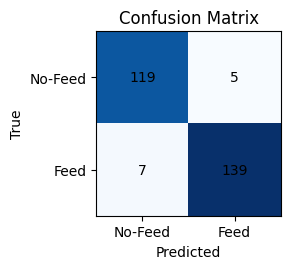

In [20]:
# Evaluation
def report(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x).argmax(1)
            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0

    print(f'Accuracy   : {acc:.4f}')
    print(f'Precision  : {prec:.4f}')
    print(f'Recall     : {rec:.4f}')
    print(f'F1         : {f1:.4f}')
    print(f'Specificity: {spec:.4f}')
    print(f'FPR        : {fpr:.4f}')

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, cmap='Blues')
    plt.xticks([0, 1], ['No-Feed', 'Feed'])
    plt.yticks([0, 1], ['No-Feed', 'Feed'])
    plt.title('Confusion Matrix')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

report(val_dl)